# Example Notebook: Neuron Synapse Competition

## Load in and Wrangle Training Data

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#load in training data on each potential synapse
data = pd.read_csv("./train_data.csv")

#load in additional features for each neuron
feature_weights = pd.read_csv("./feature_weights.csv")
morph_embeddings = pd.read_csv("./morph_embeddings.csv")

#### Basic info on these dataframes

In [70]:
print("Main Dataframe Size:",data.shape)
print("\nMain Dataframe:")
data.info()

print("\nFeature Weights Size:",feature_weights.shape)
print("\nFeature Weights:")
feature_weights.info(verbose=False)

print("\nMorphological Embeddings Size:",morph_embeddings.shape)
print("\nMorphological Embeddings:")
morph_embeddings.info(verbose=False)

Main Dataframe Size: (185832, 30)

Main Dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185832 entries, 0 to 185831
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score             

See the documentation for additional information on these features.  The main dataframe contains features for each potential synapse (each row).  The outcome to predict is 'connected'.  Note that many of the raw features in this dataframe will not be directly useful for prediction (e.g. x,y,z coordiantes, pre- and post-synapse neuron ID and etc.).  You will need to creatively engineer new features that will be more useful for prediction.

The additional information on feature weights and morphological embeddings are given for each separate neuron (the neuron ID is matched with that in the main dataframe).  These will need to be merged with the other data to create training and test sets. 

#### Merge Data

Before merging, we concatenate the feature weights and morphological embeddings into np.array's to decrease memory usage.

In [71]:
# join all feature_weight_i columns into a single np.array column
feature_weights["feature_weights"] = (
    feature_weights.filter(regex="feature_weight_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the feature_weight_i columns
feature_weights.drop(
    feature_weights.filter(regex="feature_weight_").columns, axis=1, inplace=True
)

# join all morph_embed_i columns into a single np.array column
morph_embeddings["morph_embeddings"] = (
    morph_embeddings.filter(regex="morph_emb_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the morph_embed_i columns
morph_embeddings.drop(
    morph_embeddings.filter(regex="morph_emb_").columns, axis=1, inplace=True
)

In [72]:
data = (
    data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x), 
        how="left", 
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

In [73]:
print("Data Size:",data.shape)
print("\nData:")
data.info()

Data Size: (185832, 34)

Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185832 entries, 0 to 185831
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score                  185832 non-null

## Basic Exploratory Analysis

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

### Unbalanced Data

The outcomes, the adps that form a connection or synapse ('connected'==True) and the adps that do not synapse ('connected'==False), are unbalanced:

In [25]:
print("Number Connected (Synapses):",data['connected'].sum())

print("\nNumber Not Connected:",(~data['connected']).sum())

Number Connected (Synapses): 1366

Number Not Connected: 184466


The number of presynaptic neurons and postsynaptic neurons are also unbalanced:

In [26]:
print(f"All the adps are from {data['pre_nucleus_id'].nunique()} pre- neurons and {data['post_nucleus_id'].nunique()} post- neurons.")

All the adps are from 77 pre- neurons and 2663 post- neurons.


### Exploration: Synaptic Proximity Distance 

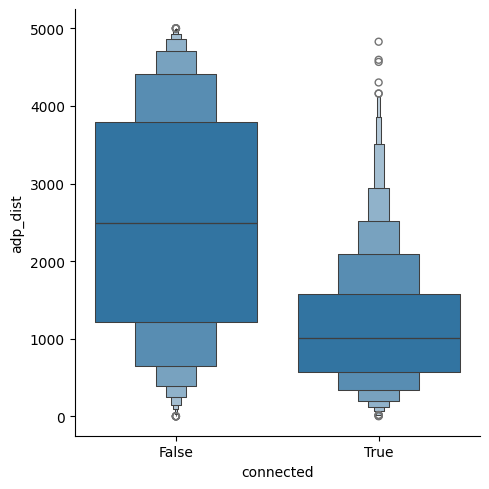

In [27]:
sns.catplot(data=data, x='connected', y='adp_dist', kind='boxen')

Neurons that form a synpase ('connected') tend to be closer together (smaller distance between pre- and post-synaptic ADP - 'adp_dist').

## Example: Basic Feature Engineering

### Exploration: Neurons that form a synpase tend to have similar functional neural responses

Neurons in the visual cortex each respond differently to visual stimuli.  This is often captured by a neuron's tuning function, or the visual features that drive a neuron to fire.  The feature weight vectors ('feature_weights') are a kind of summary of each neuron's tuning function.  Neuroscience suggests that neurons with similar tuning are slightly more likely to be connected.  To assess this, we would need to engineer a new feature that capture the tuning similarity of the pre- and post- synaptic neurons for each ADP.  (See the documentation for more details).  

In [28]:
import math
#cosine similarity function
def row_feature_similarity(row):
    pre = row["pre_feature_weights"]
    post = row["post_feature_weights"]
    return (pre * post).sum() / (np.linalg.norm(pre) * np.linalg.norm(post))

def row_feature_similarity_morph(row):
    pre = row["pre_morph_embeddings"]
    post = row["post_morph_embeddings"]
    if not isinstance(pre, np.ndarray):
        return 0
    return (pre * post).sum() / (np.linalg.norm(pre) * np.linalg.norm(post))
def row_feature_similarity_rfx(row):
    prex = row["pre_rf_x"]
    postx = row["post_rf_x"]
    return abs(prex-postx)
    
def row_feature_similarity_rfy(row):
    prey = row["pre_rf_y"]
    posty = row["post_rf_y"]
    return abs(prey-posty)

In [29]:
# compute the cosine similarity between the pre- and post- feature weights
data["fw_similarity"] = data.apply(row_feature_similarity, axis=1)
data["morph_similarity"] = data.apply(row_feature_similarity_morph, axis=1)
data["rf_x_similarity"] = data.apply(row_feature_similarity_rfx, axis=1)
data["rf_y_similarity"] = data.apply(row_feature_similarity_rfy, axis=1)


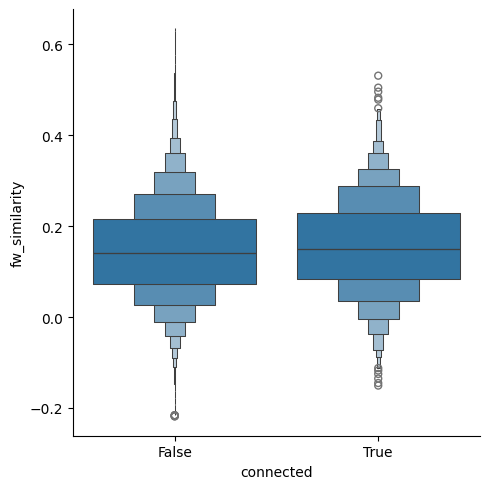

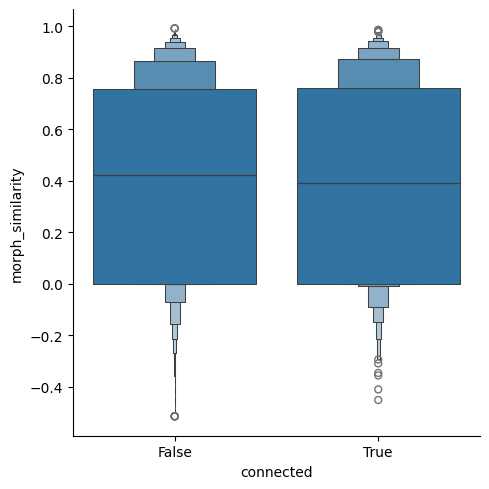

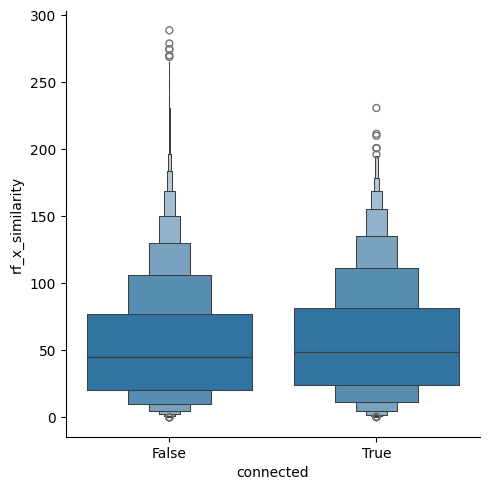

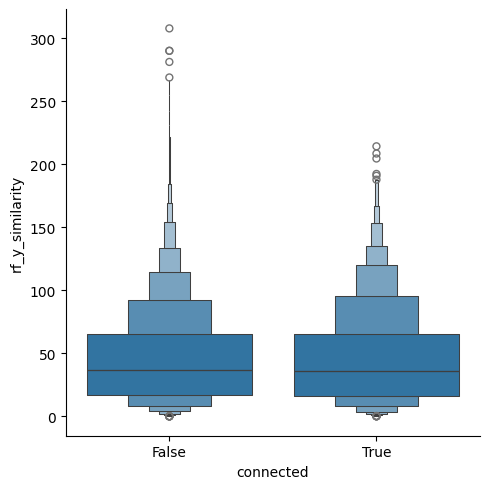

In [30]:
#visualize these results
sns.catplot(data=data, x='connected', y='fw_similarity', kind='boxen')
sns.catplot(data=data, x='connected', y='morph_similarity', kind='boxen')
sns.catplot(data=data, x='connected', y='rf_x_similarity', kind='boxen')
sns.catplot(data=data, x='connected', y='rf_y_similarity', kind='boxen')

There may be a very, very slight difference, but we can investigate this further.

### Exploration: Similar functional nerual responses by projection region in the brain

Projection regions indicate the brain regions where the pre-synaptic and post-synaptic neurons are located in the brain.  Each brain region is responsible for different neural functions.  We can engineer a new feature to capture the projection regions and perhaps see if similar neural tuning is affiliated with connecitons in particular projection regions.  For example, it has been shown that connected neurons have slightly more similar neural tuning than unconnected neurons in the V1->V1 projection region.

In [31]:
# generate projection group as pre->post
data["projection_group"] = (
    data["pre_brain_area"].astype(str)
    + "->"
    + data["post_brain_area"].astype(str)
)
data = pd.get_dummies(data, columns=['projection_group'],dtype=float)
data = pd.get_dummies(data, columns=['compartment'],dtype=float)

In [32]:
# check the distribution of the cosine similarity for projections groups with more than 100 synapses
projection_group_counts = data.query('connected')['projection_group'].value_counts()
projection_group_counts = projection_group_counts[projection_group_counts > 100].index
sns.displot(
    data=data.query('projection_group in @projection_group_counts'), 
    x='fw_similarity', 
    hue='connected', 
    row='projection_group',
    common_norm=False, 
    stat='probability',
    binwidth=.02,
    height=2,
    aspect=4,
    facet_kws={'sharey': False}
)

KeyError: 'projection_group'

In [33]:
sns.catplot(data=data, x='projection_group', y='fw_similarity', hue='connected', kind='bar', alpha=.7)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.xticks(rotation=90);

ValueError: Could not interpret value `projection_group` for `x`. An entry with this name does not appear in `data`.

We have shown some simple examples of how to engineer new features and also shown that these are related to neuron connectivity.  You will likley need to explore and engineer many other possible features in this competition.  

# One-hot encoding
- Projection group, done
- Compartment, done
# Other
- Pre-rf-postrf, done

In [34]:
# Data prep function
def adjust_data(data):
    data["fw_similarity"] = data.apply(row_feature_similarity, axis=1)
    data["morph_similarity"] = data.apply(row_feature_similarity_morph, axis=1)
    data["rf_x_similarity"] = data.apply(row_feature_similarity_rfx, axis=1)
    data["rf_y_similarity"] = data.apply(row_feature_similarity_rfy, axis=1)
    
    
    data["projection_group"] = (
        data["pre_brain_area"].astype(str)
        + "->"
        + data["post_brain_area"].astype(str)
    )
    data = pd.get_dummies(data, columns=['projection_group'],dtype=float)
    data = pd.get_dummies(data, columns=['compartment'],dtype=float)
    data = data.loc[:, ~data.columns.isin(['ID','pre_brain_area', 'post_brain_area','pre_feature_weights','post_feature_weights','pre_morph_embeddings','post_morph_embeddings'])]
    return data

## Example: Simple Logistic Regression

Now that we have shown some features are associated with neuron connectivity, we fit a simple calssification model: Logistic Regression.

In [35]:
# logistic regression model (connected ~ fw_similarity + adp)
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import Perceptron
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#Picking data earlier bc too many features
data1 = data.loc[:, ~data.columns.isin(['ID','pre_brain_area', 'post_brain_area','pre_feature_weights','post_feature_weights','pre_morph_embeddings','post_morph_embeddings'])]
data1.info()
# split into a train and test set 
#(Even though we're working with the competition training set, you may want to have your own internal train and test sets.)
#train_data, test_data = train_test_split(data, test_size=0.2, random_state=1)
train_data, test_data = train_test_split(data1, test_size=0.2, random_state=1)

# create pipeline
#pipe = Pipeline(
#    [("scaler", StandardScaler()), ("model", LogisticRegression(random_state=2))]
#)
#pipe = Pipeline(
#    [("scaler", StandardScaler()), ("model", RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1]))]
#)
pipe = Pipeline(
    [("scaler", StandardScaler()), ("model", RidgeClassifierCV())]
)

# fit model
#pipe.fit(train_data[["fw_similarity", "adp_dist"]], train_data["connected"])
#test_data["pred"] = pipe.predict(test_data[["fw_similarity","adp_dist"]])
#pipe.score(test_data[["fw_similarity","adp_dist"]],test_data['connected'])
train_x = train_data.loc[:, train_data.columns != "connected"]
train_y = train_data["connected"]

test_x = test_data.loc[:, test_data.columns != "connected"]
test_y = test_data["connected"]

pipe.fit(train_x, train_y)
test_data["pred"] = pipe.predict(test_x)
pipe.score(test_x,test_y)

## predict on test data
#test_data["pred"] = pipe.predict_proba(test_data[["fw_similarity", "adp_dist"]])[:, 1]
#
## compute accuracy
#print(f"accuracy: {accuracy_score(test_data['connected'], test_data['pred'] > .5)}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185832 entries, 0 to 185831
Data columns (total 46 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   axonal_coor_x                   185832 non-null  int64  
 1   axonal_coor_y                   185832 non-null  int64  
 2   axonal_coor_z                   185832 non-null  int64  
 3   dendritic_coor_x                185832 non-null  int64  
 4   dendritic_coor_y                185832 non-null  int64  
 5   dendritic_coor_z                185832 non-null  int64  
 6   adp_dist                        185832 non-null  float64
 7   post_skeletal_distance_to_soma  185832 non-null  float64
 8   pre_skeletal_distance_to_soma   185832 non-null  float64
 9   pre_oracle                      185832 non-null  float64
 10  pre_test_score                  185832 non-null  float64
 11  pre_rf_x                        185832 non-null  float64
 12  pre_rf_y        

0.9927085855732236

Wow.  This looks like terrific accuracy.  But, remember the data is unbalanced.  Let's check the confusion matrix.

In [36]:
#confusion_matrix(test_data['connected'], test_data['pred'] > .5)
confusion_matrix(test_y, test_data['pred'] > .5)

array([[36896,     0],
       [  271,     0]])

The model always predicts not connected!  We need a new evaluation metric.

### Balanced Accuracy Metric

Sensitivity = True Positive Rate = True Positive / (True Positive + False Negative)
Specificity = True Negative Rate = True Negative / (True Negative + False Positive)

Balanced Accuracy = (Sensitivity + Specificity)/2

In [37]:
print(
    f"balanced accuracy: {balanced_accuracy_score(test_data['connected'], test_data['pred'] > .5)}"
)

balanced accuracy: 0.5


In [38]:
#data.info()

## Data Augmentation for Unbalanced Classification

As our simple model always predicts not connected, we need to use some technique that balances the two classes.  While there are many strategies one can employ, we demostrate a simple random over sampling strategy that uses the bootstrap to augment the data for the minority ('connected') class.  

In [39]:
from imblearn.over_sampling import RandomOverSampler

# oversample connected neuron pairs
ros = RandomOverSampler(random_state=0)
# X_resampled, y_resampled = ros.fit_resample(train_data[["fw_similarity", "adp_dist"]], train_data["connected"])
# Oversample but with all features
X_resampled, y_resampled = ros.fit_resample(train_x,train_y)

# fit model
pipe.fit(X_resampled, y_resampled)

# predict on test data
#test_data["pred"] = pipe.predict(test_data[["fw_similarity","adp_dist"]])
#test_data["pred"] = pipe.predict_proba(test_data[["fw_similarity", "adp_dist"]])[:, 1]
test_data["pred"] = pipe.predict(test_x)
                                 
# compute accuracy
print(f"accuracy: {accuracy_score(test_data['connected'], test_data['pred'] > .5)}")

# confusion matrix
print(confusion_matrix(test_data['connected'], test_data['pred'] > .5))

# compute balanced accuracy
print(
    f"balanced accuracy: {balanced_accuracy_score(test_data['connected'], test_data['pred'] > .5)}"
)

accuracy: 0.682756208464498
[[25136 11760]
 [   31   240]]
balanced accuracy: 0.7834375590069864


Simple data augmentation improves our balanced accuracy dramatically!

In [40]:
list(X_resampled)

['axonal_coor_x',
 'axonal_coor_y',
 'axonal_coor_z',
 'dendritic_coor_x',
 'dendritic_coor_y',
 'dendritic_coor_z',
 'adp_dist',
 'post_skeletal_distance_to_soma',
 'pre_skeletal_distance_to_soma',
 'pre_oracle',
 'pre_test_score',
 'pre_rf_x',
 'pre_rf_y',
 'post_oracle',
 'post_test_score',
 'post_rf_x',
 'post_rf_y',
 'pre_nucleus_x',
 'pre_nucleus_y',
 'pre_nucleus_z',
 'post_nucleus_x',
 'post_nucleus_y',
 'post_nucleus_z',
 'pre_nucleus_id',
 'post_nucleus_id',
 'fw_similarity',
 'morph_similarity',
 'rf_x_similarity',
 'rf_y_similarity',
 'projection_group_AL->AL',
 'projection_group_AL->RL',
 'projection_group_AL->V1',
 'projection_group_RL->AL',
 'projection_group_RL->RL',
 'projection_group_RL->V1',
 'projection_group_V1->AL',
 'projection_group_V1->RL',
 'projection_group_V1->V1',
 'compartment_apical',
 'compartment_apical_shaft',
 'compartment_apical_tuft',
 'compartment_axon',
 'compartment_basal',
 'compartment_oblique',
 'compartment_soma']

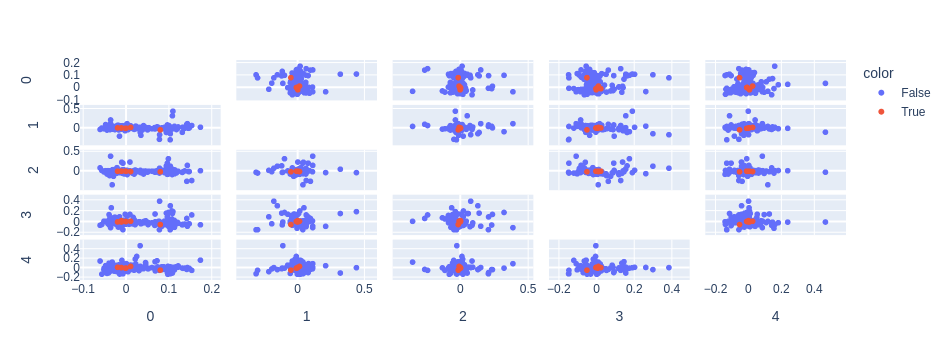

In [75]:
# PCA Test
import plotly.express as px
from sklearn.decomposition import PCA, KernelPCA

df = X_resampled
features = list(X_resampled)
#X_resampled.info()
            
#pca = PCA()
#components = pca.fit_transform(df[features])
#pca = KernelPCA(n_components=7, kernel='rbf')
#components = pca.fit_transform(df[features])

pca = PCA(n_components=4)
kernel_pca = KernelPCA(
    n_components=5, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1
)

X_pca = pca.fit(X_resampled).transform(X_resampled)
X_shrunk = X_resampled[0:1000]
X_kernel_pca = kernel_pca.fit(X_shrunk).transform(X_shrunk)


#labels = {
#    str(i): f"PC {i+1} ({var:.1f}%)"
#    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
#}

fig = px.scatter_matrix(
    X_kernel_pca,
    #labels=labels,
    dimensions=range(5),
    color=y_resampled[0:1000]
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [375]:
#Random testing
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148665 entries, 135011 to 128037
Data columns (total 46 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   axonal_coor_x                   148665 non-null  int64  
 1   axonal_coor_y                   148665 non-null  int64  
 2   axonal_coor_z                   148665 non-null  int64  
 3   dendritic_coor_x                148665 non-null  int64  
 4   dendritic_coor_y                148665 non-null  int64  
 5   dendritic_coor_z                148665 non-null  int64  
 6   adp_dist                        148665 non-null  float64
 7   post_skeletal_distance_to_soma  148665 non-null  float64
 8   pre_skeletal_distance_to_soma   148665 non-null  float64
 9   pre_oracle                      148665 non-null  float64
 10  pre_test_score                  148665 non-null  float64
 11  pre_rf_x                        148665 non-null  float64
 12  pre_rf_y        

# Random Forest

In [379]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 10, random_state = 42,verbose = 2)
# Train the model on training data
rf.fit(X_resampled, y_resampled);


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   41.1s finished


In [380]:
test_data["pred"] = rf.predict(test_x)
                                 
# compute accuracy
print(f"accuracy: {accuracy_score(test_y, test_data['pred'] > .5)}")

# confusion matrix
print(confusion_matrix(test_y, test_data['pred'] > .5))

# compute balanced accuracy
print(
    f"balanced accuracy: {balanced_accuracy_score(test_y, test_data['pred'] > .5)}"
)

accuracy: 0.9917668899830495
[[36855    41]
 [  265     6]]
balanced accuracy: 0.510514494916198


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


# Bagging, broken rn

In [382]:
# Import the necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


class BaggingClassifier:
    def __init__(self, base_classifier, n_estimators):
        self.base_classifier = base_classifier
        self.n_estimators = n_estimators
        self.classifiers = []
 
    def fit(self, X, y):
        for _ in range(self.n_estimators):
            # Bootstrap sampling with replacement
            indices = np.random.choice(len(X), len(X), replace=True)
            X_sampled = X[indices]
            y_sampled = y[indices]
 
            # Create a new base classifier and train it on the sampled data
            classifier = self.base_classifier.__class__()
            classifier.fit(X_sampled, y_sampled)
 
            # Store the trained classifier in the list of classifiers
            self.classifiers.append(classifier)
        return self.classifiers
 
    def predict(self, X):
        # Make predictions using all the base classifiers
        predictions = [classifier.predict(X) for classifier in self.classifiers]
        # Aggregate predictions using majority voting
        majority_votes = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
 
        return majority_votes
 
# Create the base classifier
dc = DecisionTreeClassifier()
model = BaggingClassifier(base_classifier=dc, n_estimators=10)
classifiers = model.fit(X_resampled, y_resampled)
 
# Make predictions on the test set
y_pred = model.predict(X_test)
 
# compute accuracy
print(f"accuracy: {accuracy_score(test_y, y_pred > .5)}")

# confusion matrix
print(confusion_matrix(test_y, y_pred > .5))

# compute balanced accuracy
print(
    f"balanced accuracy: {balanced_accuracy_score(test_y, y_pred > .5)}"
)

KeyError: "None of [Index([155163, 149797,  46598, 241233, 161451,  55366, 225064, 154776,  45672,\n       264309,\n       ...\n        46095,  48371, 290509, 146458,  16857, 206034, 152032,  91718,  35852,\n       237552],\n      dtype='int64', length=295140)] are in the [columns]"

# Create Example Prediction File for Leaderboard Submission

### Load and Merge Leaderboard Data

In [361]:
#we need to first load and merge the leaderboard data to have the same format as the training set
lb_data = pd.read_csv("./leaderboard_data.csv")

In [362]:
lb_data = (
    lb_data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x), 
        how="left", 
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

In [363]:
lb_data.shape
lb_data.head

<bound method NDFrame.head of           ID  axonal_coor_x  axonal_coor_y  axonal_coor_z  dendritic_coor_x  \
0          0         527499         544761         912282            529457   
1          1        1269890         471870         837816           1271230   
2          2         666057         469875         925239            665387   
3          3         696633         453516         925806            696648   
4          4         567525         585921         888426            570714   
...      ...            ...            ...            ...               ...   
42588  42588         765513         818622         870114            766346   
42589  42589         784476         609000         828177            782564   
42590  42590         766038         773808         861693            763428   
42591  42591         738276         614460         855099            741617   
42592  42592         769314         457443         874419            771959   

       dendritic_coor

### Example Prediction

Now we fit a our logistic regression model on the full training data and use it to make predictions on the leaderboard data. But first, we need to add in our new engineered feature on neural tuning similarity.  

In [364]:
#Adjust data
IDs = lb_data["ID"]
lb_data = adjust_data(lb_data)

In [365]:
# oversample connected neuron pairs for full training data
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(
    data1.loc[:, train_data.columns != "connected"], data1["connected"]
)

# fit model
pipe.fit(X_resampled, y_resampled)

# predict on leaderboard data
#lb_data["pred"] = pipe.predict_proba(lb_data[["fw_similarity", "adp_dist"]])[:, 1]
lb_data["pred"] = pipe.predict(lb_data)
lb_data["ID"]=IDs

#create a boolean prediction solution
lb_data["connected"] = lb_data["pred"] > .5

### Example of Creating a Leaderboard Submission File

In [367]:
#columns should be ID, connected
submission_data = lb_data.filter(['ID','connected'])
submission_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42593 entries, 0 to 42592
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         42593 non-null  int64
 1   connected  42593 non-null  bool 
dtypes: bool(1), int64(1)
memory usage: 374.5 KB


In [368]:
#writing csv files
submission_data.to_csv('tbd4.csv',index=False)

# IDEAS
- Look at the regularization curves of the features to better understand correlations and etc.
- Read up on features to better understand
- ...?